In [2]:
import os
os.environ['http_proxy'] = '127.0.0.1:7890'
os.environ['https_proxy'] = '127.0.0.1:7890'

In [7]:
import ee
import pandas as pd
import numpy as np

import sklearn
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import plotnine
from plotnine import *

from tqdm.auto import tqdm
import os


import geemap

In [4]:
# authenticate earthengine api
ee.Initialize()

In [5]:
# import data from ee_asset

# the mask of the research region, which make image process faster than a vector boundary
region_mask = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992/Control_1990_1992_0").gte(0)

# the LUCC of China, import as a dictionary
LUCC_China = {f'lucc_{year}':ee.Image(f"users/wangjinzhulala/Paper_3/01_LUCC_1990_2019_china/CLCD_v01_{year}") for year in range(1990,2020)}

# my built_up data
built_up_NCP = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")

# my built_up data from the whole China region
built_up_china = ee.Image("users/wangjinzhulala/China_built_up/06_temporal_corrected_classification/Mosaic_only_forward_China_huadong_sample_ensemble").rename('b1')

# the cropland_China data
cropland_China = {f'crop_{year}':ee.Image(f"users/wangjinzhulala/Paper_3/02_cropland_5km_China/Cropland_5km_{year}") for year in range(1990,2017)}

In [10]:
# Map = geemap.Map()
# Map.addLayer(built_up_china,{'min':0,'max':10})
# Map

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

### Compare the area of the North China Plain and China_built_all

In [11]:
# compute the statistic of LUCC image in the reserach region

def compute_stats(img):
  # first updata the image with the region_mask
  img = img.mask(region_mask)
  # then compute stats
  stats = img.reduceRegion(reducer = ee.Reducer.frequencyHistogram(), 
                geometry = region_mask.geometry().bounds(), 
                scale = 30, 
                maxPixels = int(1e13), 
                tileScale = 2).getInfo()['b1']
                
  # remove background stats ('0')              
  if '0' in stats.keys():
    stats.pop('0') 
  
  # return stats
  return stats

In [12]:
# get all stats from lucc_imgs
lucc_stats = {int(k[5:]):compute_stats(LUCC_China[k]) for k in tqdm(LUCC_China.keys(),position=0, leave=True)}

# transforme stats to df
lucc_stats_df = pd.DataFrame(lucc_stats).T
lucc_stats_df.index.name = 'year'
lucc_stats_df.reset_index(inplace=True)

# compute the stats in my research
built_up_NCP_stats = pd.DataFrame({int(k):[v] for k,v in compute_stats(built_up_NCP).items()}).T
built_up_NCP_stats['year'] = 2019 - (np.array(built_up_NCP_stats.index)-1) * 3
built_up_NCP_stats = built_up_NCP_stats.sort_values('year')
built_up_NCP_stats['count'] = built_up_NCP_stats[0].cumsum()

# compute the stats in my research of China_built_all dataset
built_up_NCP_China_stats = pd.DataFrame({int(k):[v] for k,v in compute_stats(built_up_china).items()}).T
built_up_NCP_China_stats['year'] = 2019 - (np.array(built_up_NCP_China_stats.index)-1) * 3
built_up_NCP_China_stats = built_up_NCP_China_stats.sort_values('year')
built_up_NCP_China_stats['count'] = built_up_NCP_China_stats[0].cumsum()

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# save/read df to disk
lucc_stats_df.to_csv('./result_csv/Pix_count_lucc_china.csv',index=False)
built_up_NCP_stats.to_csv('./result_csv/Pix_count_built_up_NCP.csv',index=False)
built_up_NCP_China_stats.to_csv('./result_csv/Pix_count_built_up_NCP_China_stats.csv',index=False)

lucc_stats_df = pd.read_csv('./result_csv/Pix_count_lucc_china.csv')
built_up_NCP_stats = pd.read_csv('./result_csv/Pix_count_built_up_NCP.csv')
built_up_NCP_China_stats = pd.read_csv('./result_csv/Pix_count_built_up_NCP_China_stats.csv')

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


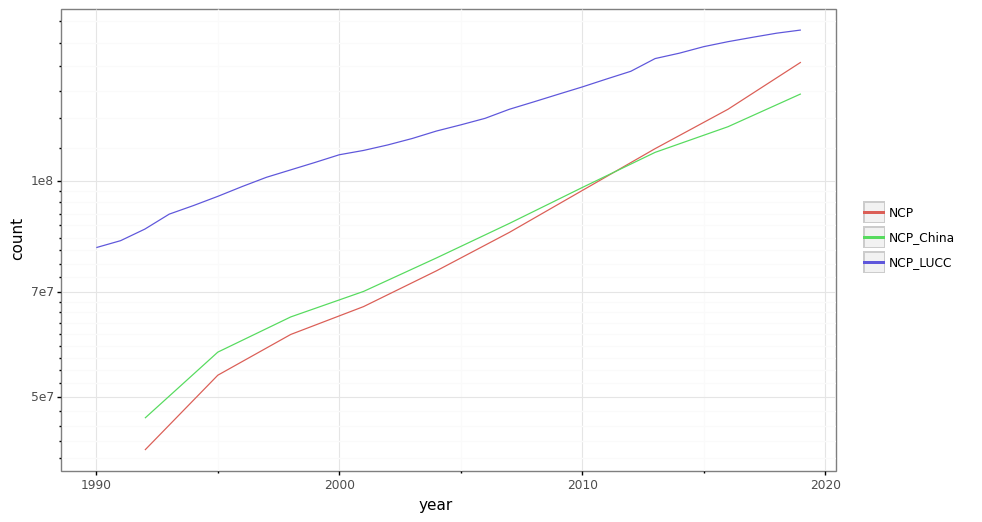

<ggplot: (8772893541801)>

In [ ]:
plotnine.options.figure_size = (10,6)
plotnine.options.dip = 200

(ggplot() +
 geom_line(built_up_NCP_stats,aes('year','count',color=['NCP'])) +
 geom_line(built_up_NCP_China_stats,aes('year','count',color=['NCP_China'])) +
 geom_line(lucc_stats_df,aes('year','8',color=['NCP_LUCC'])) +
 scale_y_log10() +
 theme_bw() +
 theme(legend_title=element_blank())
 )

### Project to the future

In [ ]:
from sklearn.linear_model import LinearRegression
import scipy

# 1) fit built_up_NCP_stats

x = built_up_NCP_stats['year'].values
y = built_up_NCP_stats['count'].values

# fit the urban pixel count, note the p0 were created from additional Excel Trend Line
coef,_ = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t), x, y, p0=[1e-30,0.04])

# get the coefficients
fit_val   = coef[0]*np.exp(coef[1]*x)
fit_val_ext = coef[0]*np.exp(coef[1]*np.arange(1990,2030))



# 2) fit built_up_NCP_China_stats
X = built_up_NCP_China_stats['year'].values.reshape(-1,1)
Y = built_up_NCP_China_stats['count'].values.reshape(-1,1)

reg = LinearRegression().fit(X, y)
fit_NCP_China = reg.predict(np.arange(1990,2030).reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


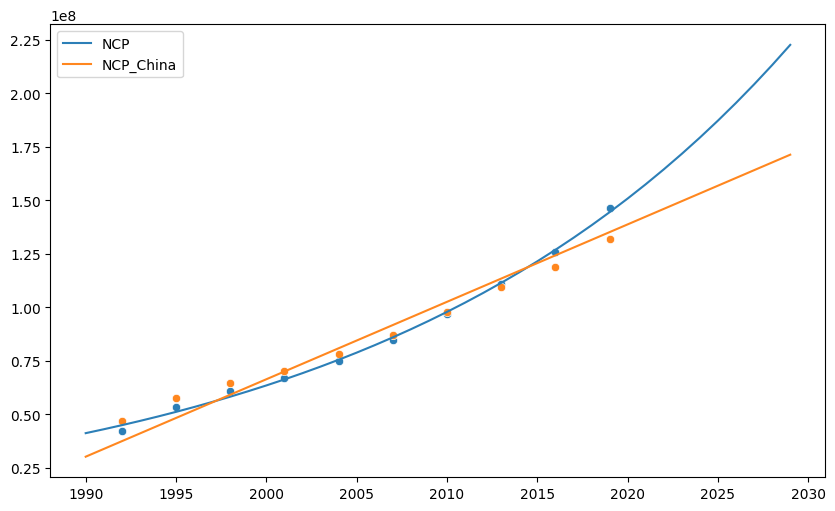

In [ ]:
plt.figure(figsize=(10,6),dpi=100)

sns.lineplot(x=np.arange(1990,2030),y=fit_val_ext,color='#2c7fb7',label='NCP')
sns.scatterplot(x=x,y=y,color='#2c7fb7')

sns.lineplot(x=np.arange(1990,2030),y=fit_NCP_China.reshape(-1),color='#ff871f',label='NCP_China')
sns.scatterplot(x=X.reshape(-1),y=Y.reshape(-1),color='#ff871f')

### Compute the accuracy

In [ ]:
# evaluate an img using control samples
def eval_img(img,fe_col,eval_property = 'Built',img_property = 'b1'):
  ext_val = ee.Image(img).sampleRegions(
      collection = fe_col, 
      properties = [eval_property], 
      scale = 30,
      geometries = False).getInfo()

  eval_df = pd.DataFrame([i['properties'] for i in ext_val['features']])

  error_mat = confusion_matrix(eval_df[eval_property],eval_df[img_property])
  acc    = accuracy_score(eval_df[eval_property],eval_df[img_property]) * 100
  hit    = error_mat[1,1]/(error_mat[1,1] + error_mat[1,0]) * 100

  return acc,hit

In [ ]:
# get eval samples from ee_asset
eval_samples = ! earthengine ls users/wangjinzhulala/China_built_up/04_sample_train_test_split
eval_samples = [i for i in eval_samples if 'Grid' in i]

In [ ]:
# merge all samples in the same year_range
year_range = [f"{i}_{i+2}" for i in range(1990,2020,3)]
metics = {}


# loop through each year
for idx,year in tqdm(enumerate(year_range),total=len(year_range)):

  # get imgs
  img_built_china = built_up_china.gte(10 - idx)
  img_lucc_china = LUCC_China[f'lucc_{year[-4:]}'].eq(8)

  # loop through each region
  samples_year = [i for i in eval_samples if year in i]
  fe_col = ee.FeatureCollection([])
  for fe in samples_year:
    fe_col = fe_col.merge(fe)

  # evaluate the img quanliy using metrics
  acc_built_china,hit_built_china = eval_img(img_built_china,fe_col)
  acc_lucc_china,hit_lucc_china = eval_img(img_lucc_china,fe_col)

  # report and store data
  metics[(year,'Built_China')] = {'ACC':acc_built_china, 'Hit':hit_built_china}
  metics[(year,'LUCC_China')] = {'ACC':acc_lucc_china, 'Hit':hit_lucc_china}

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# # reshape and save df
# metrics_df = pd.DataFrame(metics).T.reset_index()
# metrics_df.columns = ['year','type','ACC','Hit']

# metrics_df_stack = metrics_df.set_index(['year','type']).stack().reset_index()
# metrics_df_stack.columns = ['year','type','metric','val']
# metrics_df_stack['year'] = metrics_df_stack['year'].astype('category')
# metrics_df_stack['year_code'] =  metrics_df_stack['year'].cat.codes

# # save df
# metrics_df_stack.to_csv('./result_csv/Built_China_accuracy.csv',index=False)

In [8]:
# read data
metrics_df_stack = pd.read_csv('./result_csv/Built_China_accuracy.csv')
metrics_df_stack['year_int'] = metrics_df_stack['year'].apply(lambda x:int(x[-4:]))
metrics_df_stack.head()

,year,type,metric,val,year_code,year_int
0,1990_1992,Built_China,ACC,94.000945,0,1992
1,1990_1992,Built_China,Hit,88.096363,0,1992
2,1990_1992,LUCC_China,ACC,88.568729,0,1992
3,1990_1992,LUCC_China,Hit,78.129428,0,1992
4,1993_1995,Built_China,ACC,94.544166,1,1995


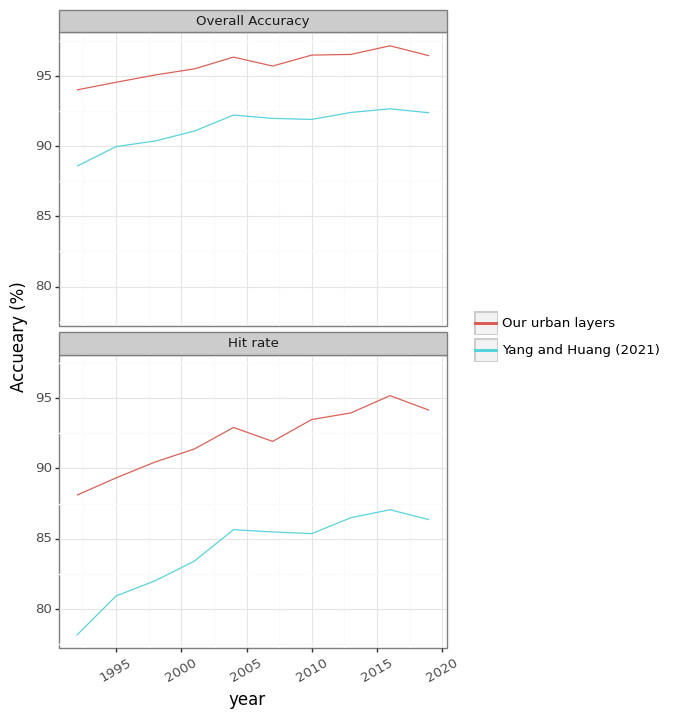

<ggplot: (8791370310661)>

In [35]:
plotnine.options.figure_size = (5,8)
plotnine.options.dip = 300

g = (ggplot(metrics_df_stack) +
 geom_line(aes(x='year_int',y='val',color='type')) +
 facet_wrap('metric',nrow=2,labeller = as_labeller({'ACC':'Overall Accuracy','Hit':'Hit rate'})) +
 scale_x_continuous(breaks=range(1990,2021,5)) +
 xlab('year') +
 ylab('Accueary (%)') +
 scale_color_discrete(labels = ['Our urban layers','Yang and Huang (2021)']) +
 theme_bw(base_size=12) +
 theme(axis_text_x=element_text(rotation=30),legend_title=element_blank())
 )

g

In [36]:
g.save('/content/sup_6_urban_acc_compare.svg')

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 5 x 8 in image.
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /content/sup_6_urban_acc_compare.svg
